## Advanced Lane Finding Project


Steps for the pipeline are;

1. Camera calibration
1. Distortion correction
1. Color/gradient threshold
1. Perspective transform
1. Detect lane lines
1. Determine the lane curvatur

In [1]:
# Code cell 1
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

%matplotlib inline



## Calibrate The Camera

In [2]:
# Code Cell 2
class CalibrateCamera:
    # Note these are class variables, so you only every have to read images once
    ret, mtx, dist, rvecs, tvecs = None,None,None,None,None
    objpoints = []
    imgpoints = []
    cal_images = []
    
    def __init__(self):
        self.readCalibrationImages()

    def readCalibrationImages(self):
        if len (self.cal_images) > 0:
            return
        # prepare object points
        nx = 9 #TODO: enter the number of inside corners in x
        ny = 6 #TODO: enter the number of inside corners in y

        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x,y coord

        images = glob.glob("./camera_cal/*.jpg")

        # Make a list of calibration images

        for fname in images:
            print (fname)
            img = mpimg.imread(fname)

            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

            # If found, draw corners
            if ret == True:
                self.imgpoints.append(corners)
                self.objpoints.append(objp)
                # Draw and display the corners
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                #print (corners[0], corners[nx-1],corners[-1],corners[-nx])

            self.cal_images.append((img,fname))

    def getCalibrationImages(self):
        return self.cal_images
    
    def getCameraCalibration(self,image_shape):
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, image_shape, None, None)

    def undistortImage(self,image):
        return cv2.undistort(image,self.mtx,self.dist,None,self.mtx)

./camera_cal/calibration5.jpg
./camera_cal/calibration4.jpg
./camera_cal/calibration6.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration1.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration8.jpg


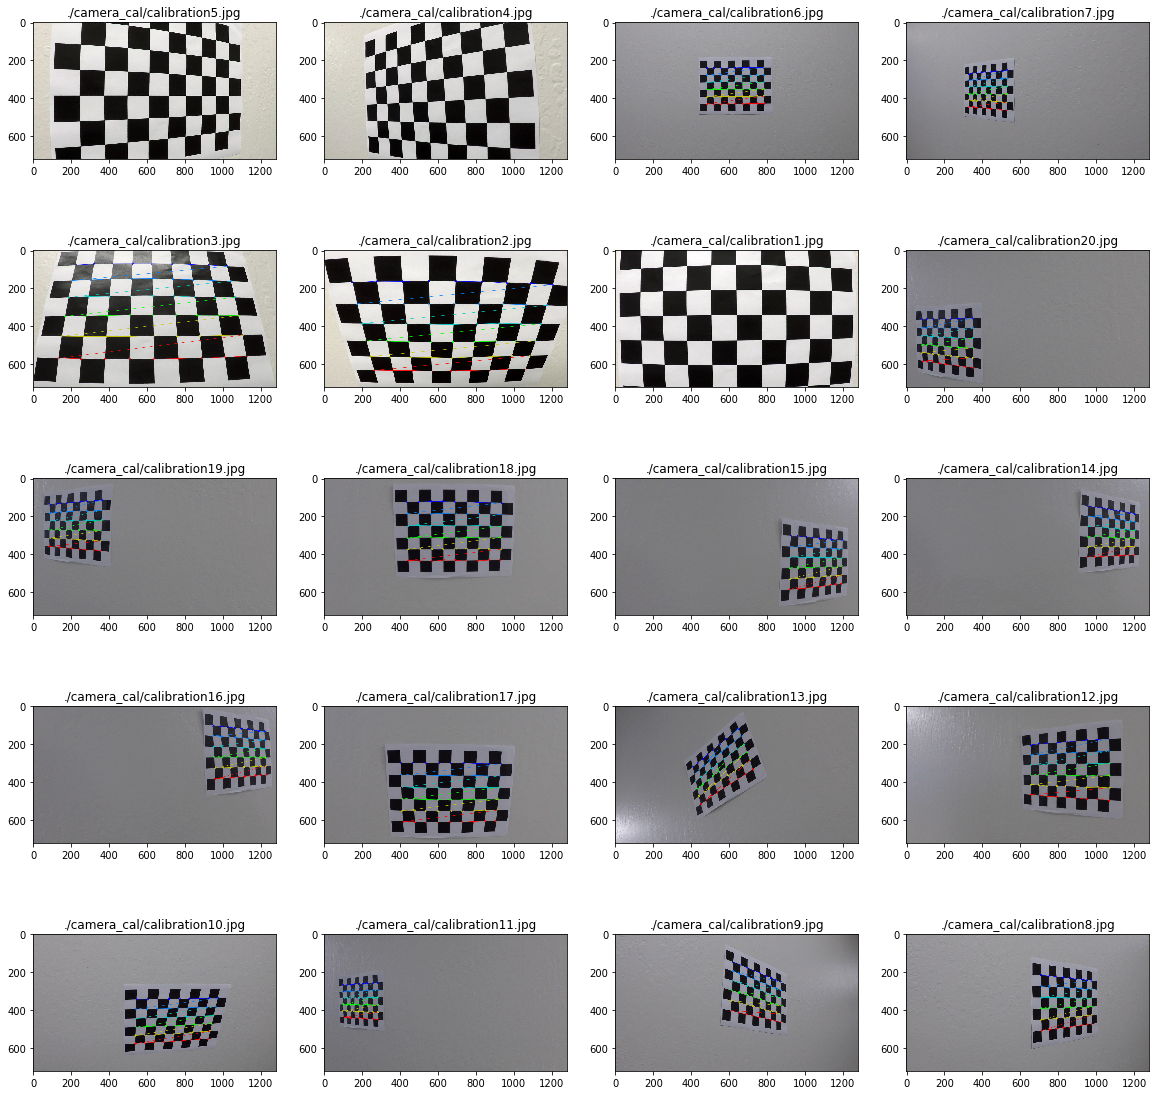

In [3]:
#Code Cell 3
camCal = CalibrateCamera()

cal_images = camCal.getCalibrationImages()


f, ax = plt.subplots(5, 4, figsize=(20, 20))

ax = ax.ravel()

for cal_image,axi in zip(cal_images,ax):
    axi.imshow(cal_image[0])
    axi.set_title(cal_image[1])

plt.subplots_adjust(hspace=0.3)
plt.show()



## Threshold Functions

## Show Chessboard Undistorted

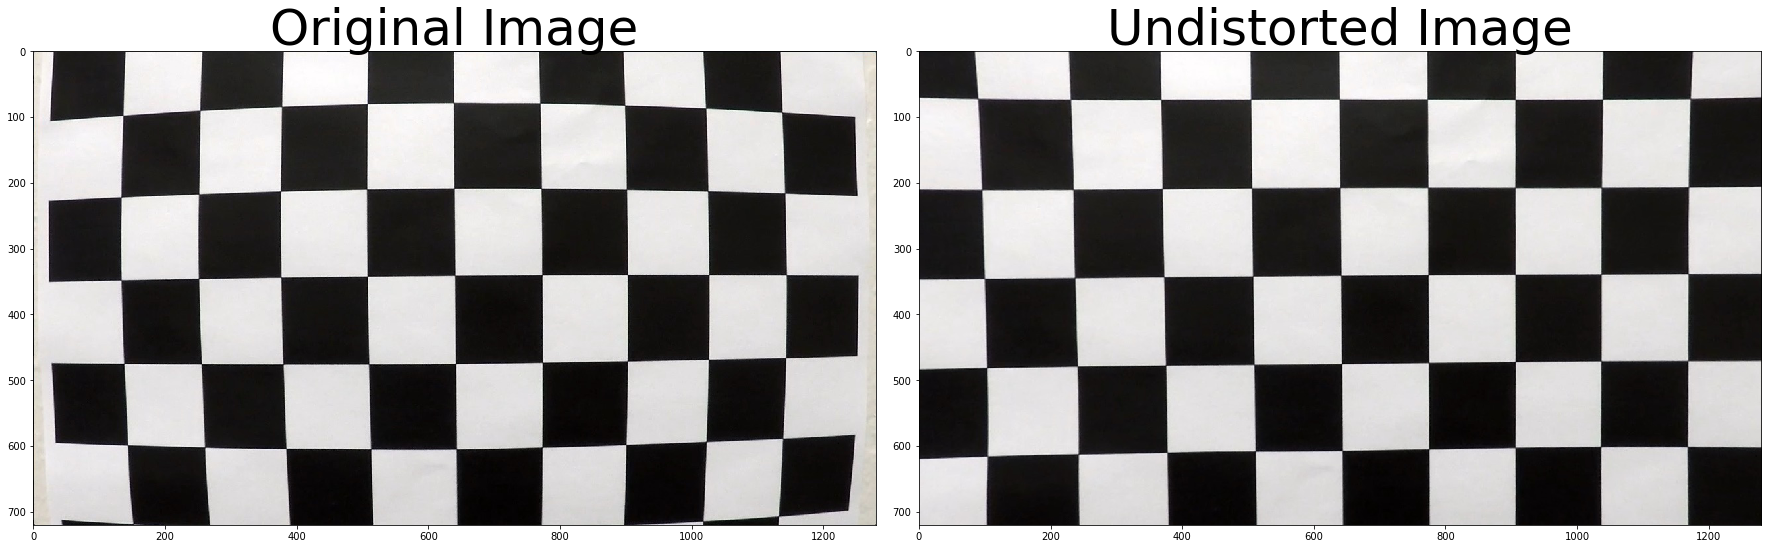

In [4]:
#Code Cell 4
cal_image = mpimg.imread("./camera_cal/calibration1.jpg")

camCal.getCameraCalibration(cal_image.shape[::-1][1:3])

undistorted = camCal.undistortImage(cal_image,)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Undistort Test Image

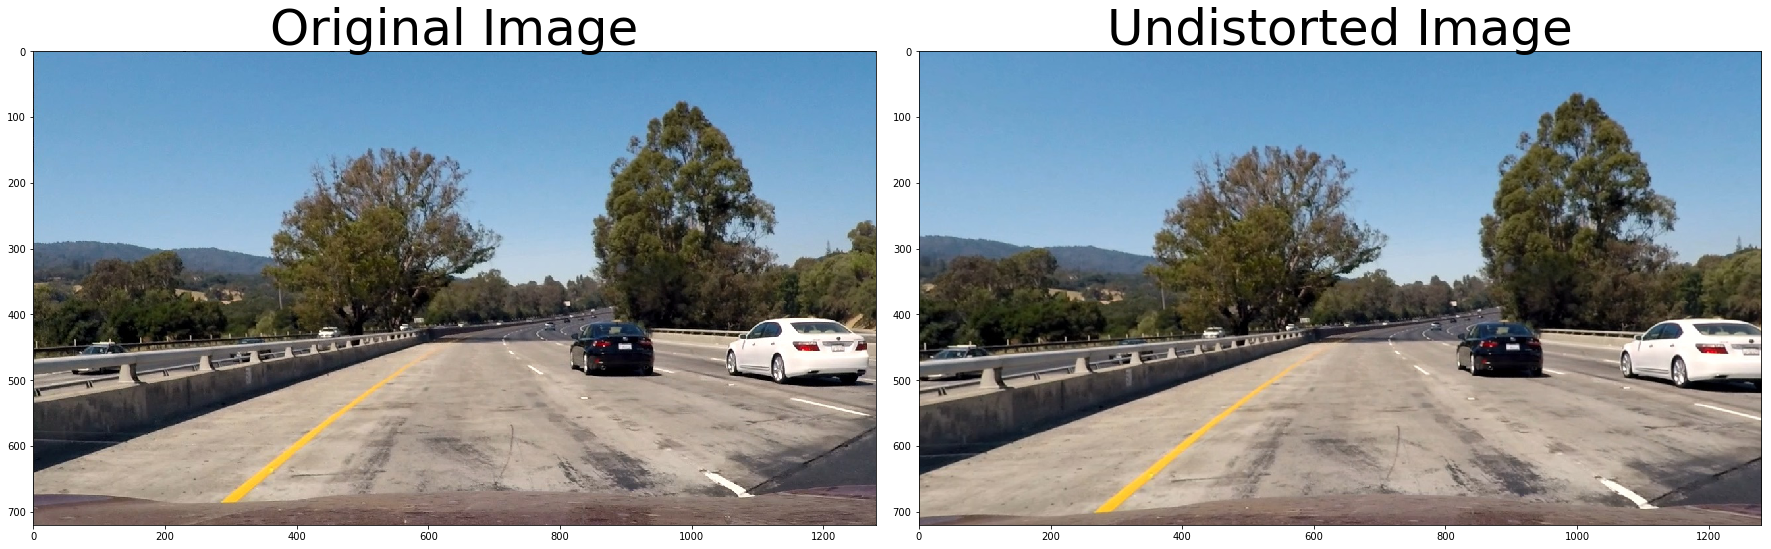

In [5]:
#Code Cell 5
cal_image = mpimg.imread("./test_images/test1.jpg")

camCal.getCameraCalibration(cal_image.shape[::-1][1:3])

undistorted = camCal.undistortImage(cal_image,)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Gradient & Threshold functions


In [6]:
#Code Cell 6
# Class that takes an image and lets you pick appropriate Channels from different
# Color spaces
class ImageChannel():
    image = None
    def __init__(self,img):
        # Initial RGB image
        self.image = img

    def getChannel(self, channel):
        """Dispatch method"""
        # Get the method from 'self'. Default to a lambda.
        method = getattr(self, channel, lambda: "nothing")
        # Call the method as we return it
        return method()

    def GRAY(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)

    def RGB_R(self):
        return image[:,:,0]

    def RGB_G(self):
        return image[:,:,1]

    def RGB_B(self):
        return image[:,:,2]

    def HLS_H(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,0]

    def HLS_L(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,1]

    def HLS_S(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,2]
    
    def HSV_H(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,0]

    def HSV_S(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,1]

    def HSV_V(self):
        return cv2.cvtColor(self.image, cv2.COLOR_RGB2HLS)[:,:,2]

    
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', channel="GRAY", sobel_kernel=3, thresh=(0,255)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, channel="GRAY", sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, channel="GRAY", sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to appropriate channel
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_thresh (img, channel="GRAY", thresh=(170,255)):
    ic = ImageChannel(img)
    img_channel = ic.getChannel(channel)

    binary = np.zeros_like(img_channel)
    binary[(img_channel >= thresh[0]) & (img_channel <= thresh[1])] = 1
    return binary



## Gradient & Threshold Visualizations

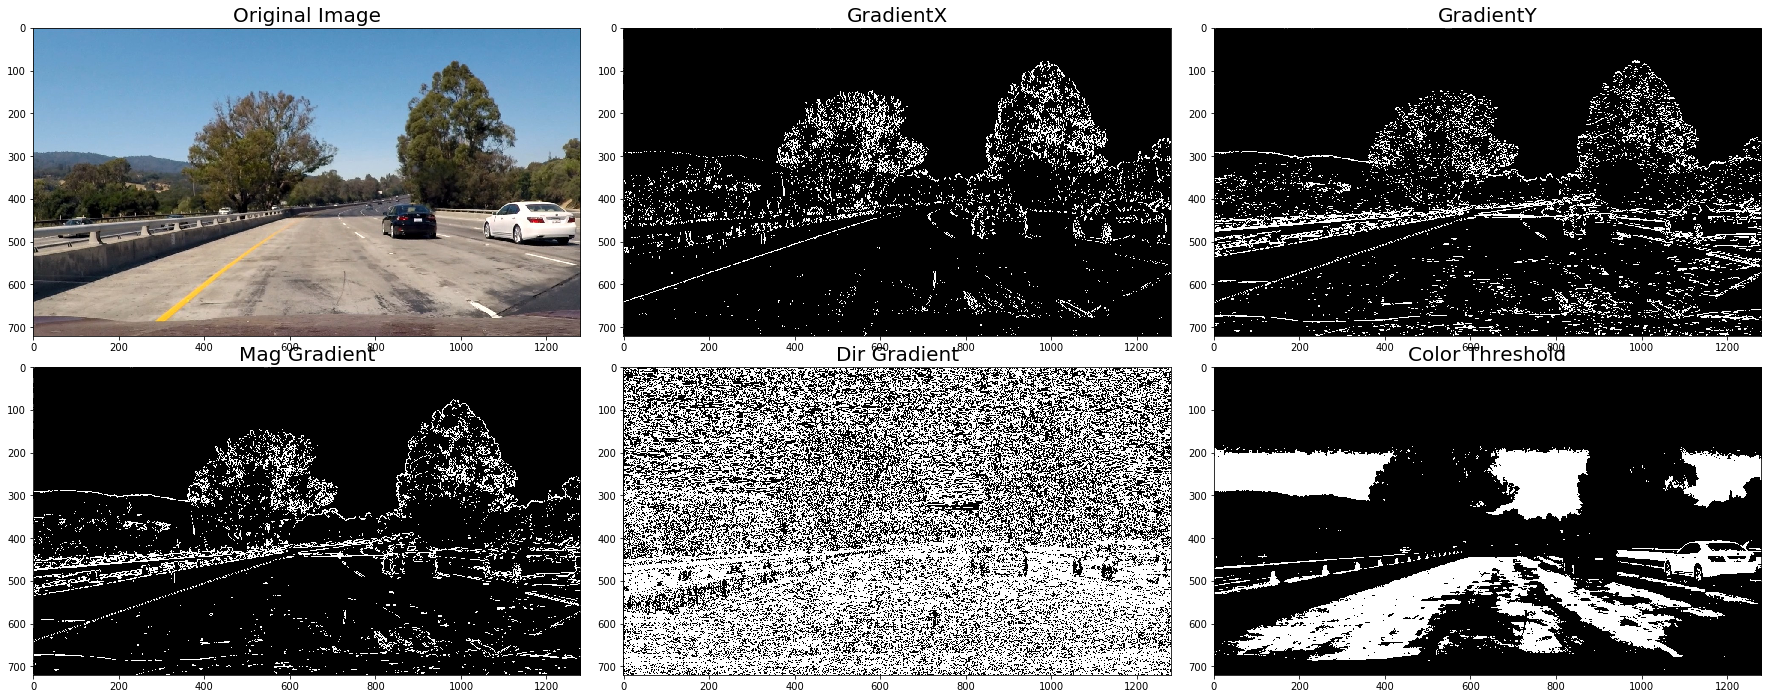

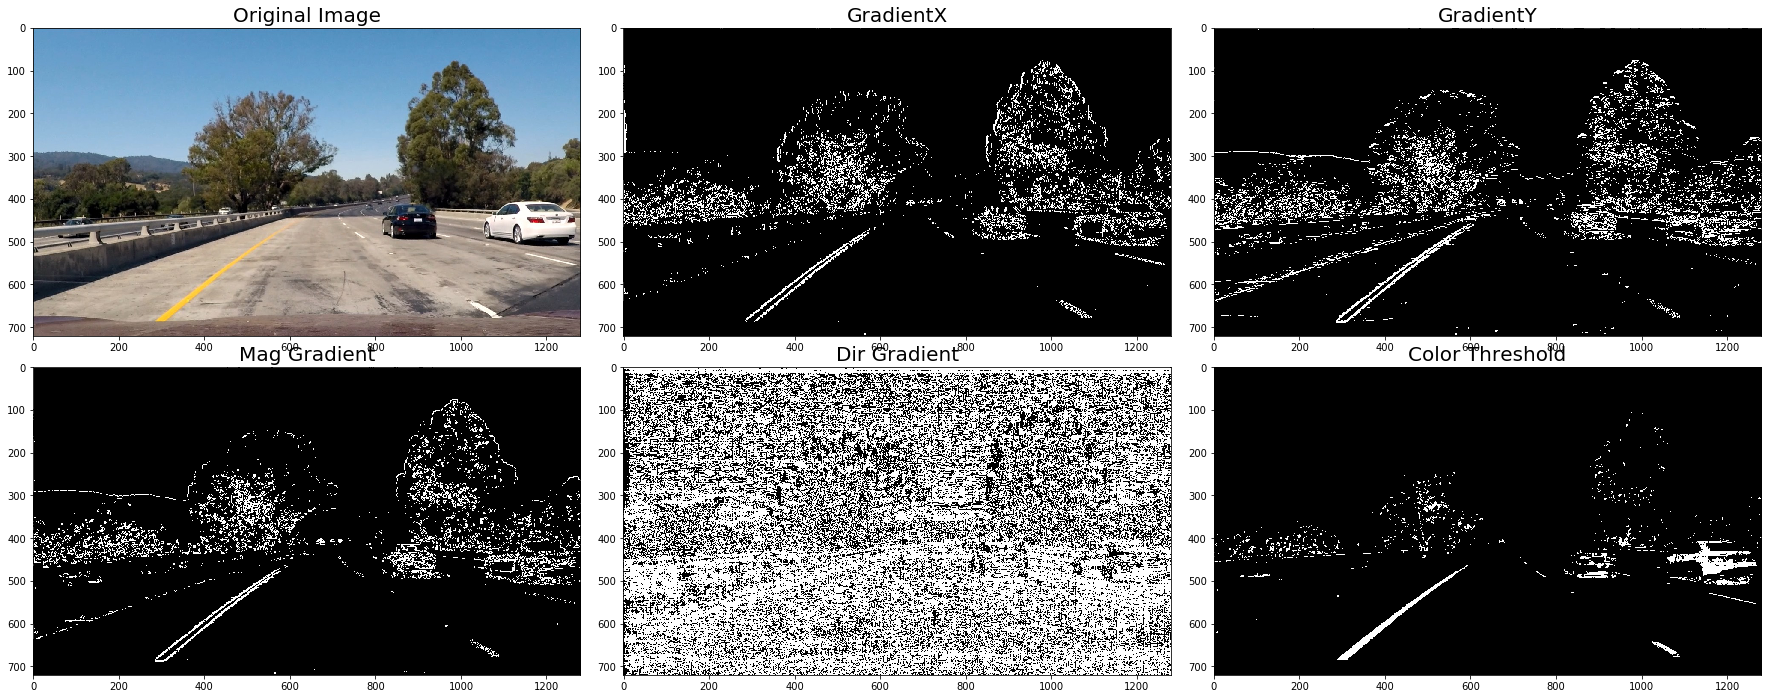

In [7]:
#Code Cell 7
# Read in an image and grayscale it
ksize = 3
image = mpimg.imread('./test_images/test1.jpg')

gradx = abs_sobel_thresh(image, orient='x', channel="GRAY", sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', channel="GRAY", sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, channel="GRAY", sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, channel="GRAY", sobel_kernel=ksize, thresh=(0.7, np.pi/2))
color_binary = color_thresh(image, channel="GRAY", thresh=(170,255))


f, ax = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(gradx, cmap='gray')
ax[1].set_title('GradientX', fontsize=20)
ax[2].imshow(grady, cmap='gray')
ax[2].set_title('GradientY', fontsize=20)
ax[3].imshow(mag_binary, cmap='gray')
ax[3].set_title('Mag Gradient', fontsize=20)
ax[4].imshow(dir_binary, cmap='gray')
ax[4].set_title('Dir Gradient', fontsize=20)
ax[5].imshow(color_binary, cmap='gray')
ax[5].set_title('Color Threshold', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

gradx = abs_sobel_thresh(image, orient='x', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, channel="HLS_S", sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, channel="HLS_S", sobel_kernel=ksize, thresh=(0.7, np.pi/2))
color_binary = color_thresh(image, channel="HLS_S", thresh=(150,255))


f, ax = plt.subplots(2, 3, figsize=(24, 10))
f.tight_layout()
ax = ax.ravel()

ax[0].imshow(image)
ax[0].set_title('Original Image', fontsize=20)
ax[1].imshow(gradx, cmap='gray')
ax[1].set_title('GradientX', fontsize=20)
ax[2].imshow(grady, cmap='gray')
ax[2].set_title('GradientY', fontsize=20)
ax[3].imshow(mag_binary, cmap='gray')
ax[3].set_title('Mag Gradient', fontsize=20)
ax[4].imshow(dir_binary, cmap='gray')
ax[4].set_title('Dir Gradient', fontsize=20)
ax[5].imshow(color_binary, cmap='gray')
ax[5].set_title('Color Threshold', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

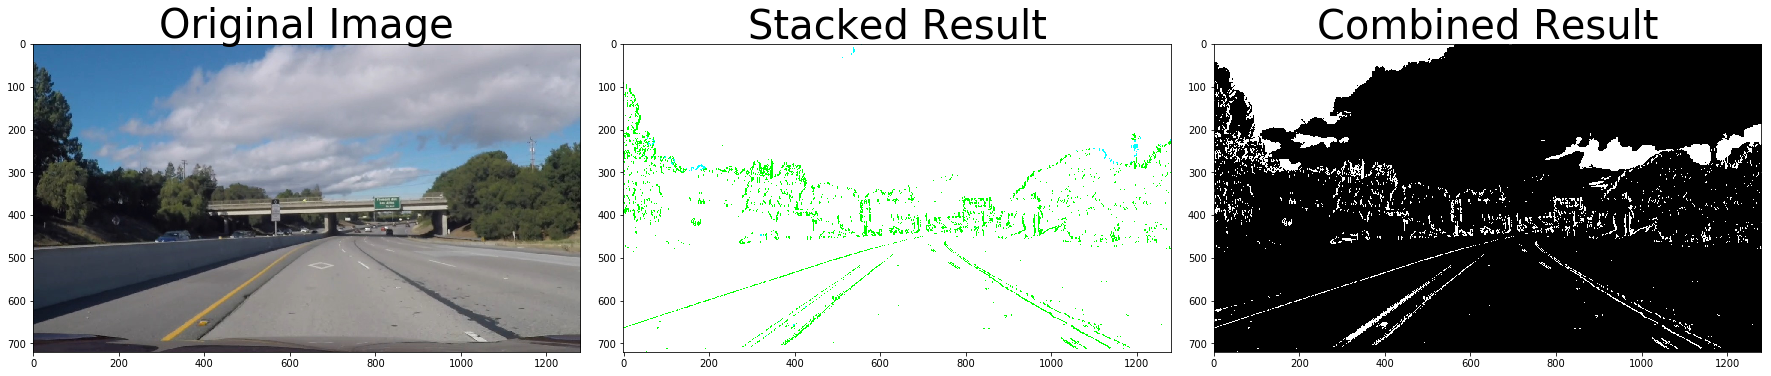

In [83]:
#Code Cell 8
image = mpimg.imread('./test_images/test11.jpg')

# Edit this function to create your own pipeline.
def pipeline(img):
    img = np.copy(img)
    undistorted = camCal.undistortImage(img)


    gradx_g = abs_sobel_thresh(undistorted, orient='x', channel="GRAY", sobel_kernel=ksize, thresh=(20, 150))
    grady_g = abs_sobel_thresh(undistorted, orient='y', channel="GRAY", sobel_kernel=15, thresh=(20, 150))
    mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(15, 100))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    
    gradx_l = abs_sobel_thresh(undistorted, orient='x', channel="HLS_L", sobel_kernel=ksize, thresh=(20, 100))
    gradx_s = abs_sobel_thresh(undistorted, orient='y', channel="HLS_S", sobel_kernel=ksize, thresh=(20, 100))
    color_s = color_thresh(image, channel="HLS_S", thresh=(100, 255))
    color_l = color_thresh(image, channel="HLS_L", thresh=(220, 255))
    color_v = color_thresh(image, channel="HSV_V", thresh=(210, 255))

    #color_t = color_thresh(undistorted, channel="HLS_S", thresh=(150,255))


    color_binary = np.dstack(( np.zeros_like(gradx_g), gradx_g, color_s, gradx_g)) * 255
    
    combined_binary = np.zeros_like(gradx)
    #combined_binary[(gradx_l ==1) | (color_t ==1) | (gradx_s==1) ] = 1
    #combined_binary[((gradx_g == 1) & (grady_g == 1)) | ((color_s == 1) | (color_l == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined_binary[((gradx_g == 1) & (grady_g == 1)) | ((color_s == 1) | (color_v == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined_binary[((gradx_l == 1) & (gradx_s == 1)) | ((color_s == 1) | (color_v == 1)) & ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined_binary[(gradx_g == 1) | (color_s == 1) | (color_v == 1)] = 1


    return color_binary, combined_binary
    
stacked, combined = pipeline(image)
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(stacked, cmap="gray")
ax2.set_title('Stacked Result', fontsize=40)

ax3.imshow(combined, cmap="gray")
ax3.set_title('Combined Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

## Perspective Transform

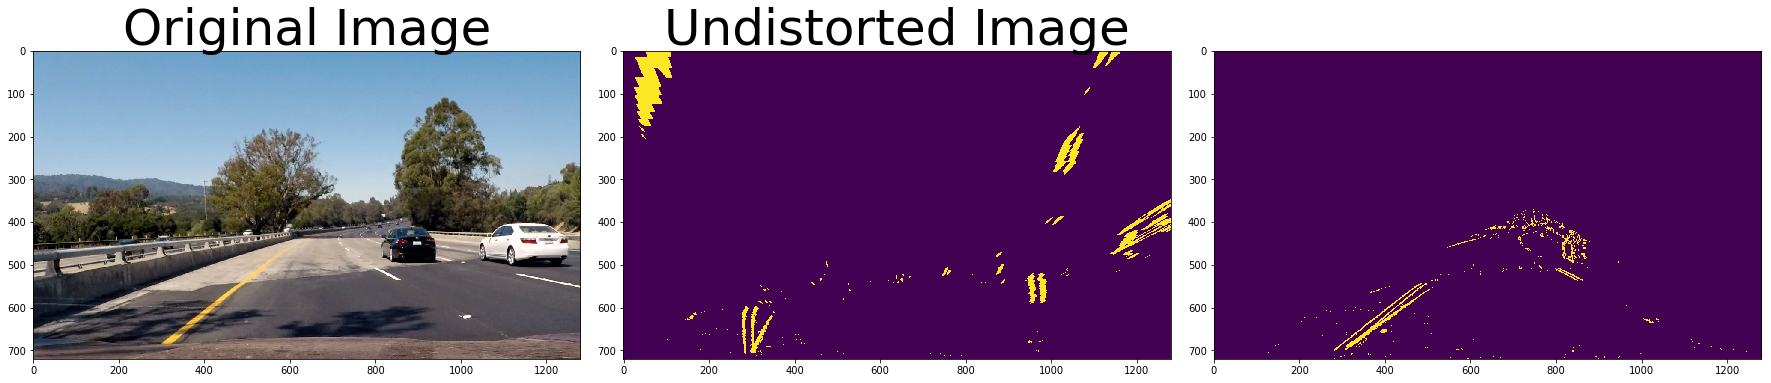

In [84]:
#Code Cell 9
def get_transform_matrix():
    img = mpimg.imread('test_images/straight_lines1.jpg')
    h,w= img.shape[:2]

    src = np.float32(
        [[685, 450], 
          [1090, 710], 
          [220, 710], 
          [595, 450]])
    
    dst = np.float32(
        [[900, 0], 
          [900, 710], 
          [250, 710], 
          [250, 0]])

#    src = np.float32(
#        [[685, 450], 
#          [1100, 710], 
#          [200, 710], 
#          [595, 450]])
#    
#    dst = np.float32(
#        [[900, 0], 
#          [900, 710], 
#          [250, 710], 
#          [250, 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M,Minv

# Remove a region of an image
def remove_region(img, triangle):
    mask = np.ones_like(img) 
    mask = cv2.fillPoly(mask, [triangle], 0)

    new_combined = np.zeros_like(img)
    new_combined[((img == 1) & (mask == 1))] = 1
    
    return new_combined

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

cal_image = mpimg.imread("./test_images/test4.jpg")

stacked,processed = pipeline(cal_image)

# Remove a piece of the road between te lanes. This removes some noise that may be in between the lane lines
#h,w= processed.shape[:2]
#triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
#processed = remove_region(processed, triangle)
pHeightMask=1.7
imshape = cal_image.shape
vertices = np.array([[(0,imshape[0]),(imshape[1]/pHeightMask, imshape[0]/2), (imshape[1]/pHeightMask, imshape[0]/2), (imshape[1],imshape[0])]], dtype=np.int32)
processed = region_of_interest(processed,vertices)
    
M,Minv = get_transform_matrix()
img_size = (processed.shape[1], processed.shape[0])
warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted Image', fontsize=50)
ax3.imshow(processed)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

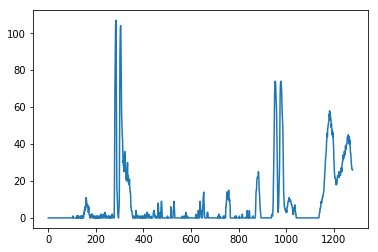

In [85]:
#Code Cell 10
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

## Orig Sliding Window


(720, 0)

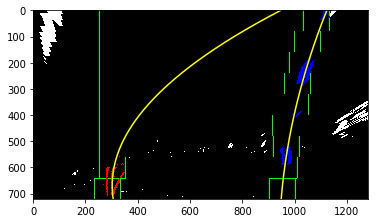

In [86]:
#Code cell 11
binary_warped = np.copy(warped)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

#print ("Left Shape->",left_fit.shape, leftx.shape, lefty.shape)
#print ("Left-> ",left_fit, leftx, lefty)
#print ("Right-> ",right_fit, right_fitx)

## Sliding Window Search (CLASS)

In [49]:
#Code Cell 12
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        # polynomial coefficients of the last n fits of the line
        self.recent_fitted = [] 
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def updateLine(self,fit, fitxPts, fityPts, radius, position):
        resetWindow = False

        if self.radius_of_curvature is None:
            diff = 0.0
        else:
            diff = abs(self.radius_of_curvature - radius)

        if (diff/radius > 0.8):
            # looks like a bad reading
            # Don't add and reset Window
            #print ("Old:",self.current_fit," New:",fit, "Diff:",diff)
            print ("Old:",self.radius_of_curvature," New:",radius, "Diff:",diff)

            resetWindow = True
        else:
            self.radius_of_curvature = radius
            self.diffs = diff
            self.current_fit = np.array(fit)
            self.recent_fitted.append(fit)
            if (len(self.recent_fitted) > 10):
                self.recent_fitted.pop(0)
            self.best_fit = np.mean(np.array(self.recent_fitted), axis=0)
            self.line_base_pos = position

            
        return resetWindow
        
    def updateLine_old(self,fit, fitxPts, fityPts, radius, position):
        resetWindow = False

        if self.current_fit is None:
            diff = np.array([0,0,0], dtype='float')
        else:
            diff = np.absolute(self.current_fit - fit)

        if (abs(diff[0]/fit[0]) > 0.3) | (abs(diff[1]/fit[1]) > 0.3) | (abs(diff[2]/fit[2]) > 0.3):
            # looks like a bad reading
            # Don't add and reset Window
            #print ("Old:",self.current_fit," New:",fit, "Diff:",diff)
            resetWindow = True
        else:
            self.diffs = diff
            self.current_fit = np.array(fit)
            self.recent_fitted.append(fit)
            if (len(self.recent_fitted) > 5):
                self.recent_fitted.pop(0)
            self.best_fit = np.mean(np.array(self.recent_fitted), axis=0)
            self.line_base_pos = position
            
        return resetWindow

class SlidingWindow():
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    
    def __init__(self):
        self.leftLine = Line()
        self.rightLine = Line()
        self.first_pass = True
        self.resetWindowParams ()
        return

    def resetWindowParams(self):
        print ("First Pass")
        self.leftLine = Line()
        self.rightLine = Line()
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.left_fit, self.right_fit, self.left_fitx, self.right_fitx, self.ploty = None,None,None,None,None
        self.left_fit_cr, self.right_fit_cr = None, None
        self.nonzeroy, self.nonzerox = None, None
        return

    def polyfit(self,binary_warped):
        resetWindow = False
        if self.first_pass:
            #print ("Polyfit: First Pass")
            self.resetWindowParams()
            self.first_pass = False
            out_img = self.sliding_window_polyfit(binary_warped)
        else:
            #print ("Polyfit: subsequent Pass")
            out_img =  self.no_sliding_polyfit(binary_warped)
            
        left_curverad, right_curverad= self.calc_curve()
        position = self.calc_lane_position(binary_warped)
        resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, left_curverad, position)
        resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, right_curverad, position)

        
        if resetWindow == True:
            # Reset Window search
            #print ("Resetting Window search....")
            self.resetWindowParams()
            out_img = self.sliding_window_polyfit(binary_warped)
            left_curverad, right_curverad= self.calc_curve()
            position = self.calc_lane_position(binary_warped)

            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, left_curverad, position)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, right_curverad, position)
        return out_img
    
    def polyfit_old(self,binary_warped):
        resetWindow = False
        if self.first_pass:
            #print ("Polyfit: First Pass")
            self.resetWindowParams()
            self.first_pass = False
            out_img = self.sliding_window_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        else:
            #print ("Polyfit: subsequent Pass")
            out_img =  self.no_sliding_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        
        if resetWindow == True:
            # Reset Window search
            #print ("Resetting Window search....")
            self.resetWindowParams()
            out_img = self.sliding_window_polyfit(binary_warped)
            resetWindow |= self.leftLine.updateLine(self.left_fit, self.left_fitx, self.ploty, 0, 0)
            resetWindow |= self.rightLine.updateLine(self.right_fit, self.right_fitx, self.ploty, 0, 0)
        return out_img

    def sliding_window_polyfit(self,binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        self.left_lane_inds = []
        self.right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            self.left_lane_inds.append(good_left_inds)
            self.right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        self.left_lane_inds = np.concatenate(self.left_lane_inds)
        self.right_lane_inds = np.concatenate(self.right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]
        
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Fit new polynomials to x,y in world space
        self.left_fit_cr = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        self.right_fit_cr = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        
        self.nonzerox = nonzerox
        self.nonzeroy = nonzeroy
        return out_img

    def plot_windows(self,binary_warped, out_img, ax):
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        ax.imshow(out_img)
        ax.plot(self.left_fitx, self.ploty, color='yellow')
        ax.plot(self.right_fitx, self.ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)
        #plt.show()
        
    def no_sliding_polyfit(self, binary_warped):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        self.left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
        self.left_fit[2] - self.margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
        self.left_fit[1]*nonzeroy + self.left_fit[2] + self.margin))) 

        self.right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
        self.right_fit[2] - self.margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
        self.right_fit[1]*nonzeroy + self.right_fit[2] + self.margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[self.left_lane_inds]
        lefty = nonzeroy[self.left_lane_inds] 
        rightx = nonzerox[self.right_lane_inds]
        righty = nonzeroy[self.right_lane_inds]
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Fit new polynomials to x,y in world space
        self.left_fit_cr = np.polyfit(lefty*self.ym_per_pix, leftx*self.xm_per_pix, 2)
        self.right_fit_cr = np.polyfit(righty*self.ym_per_pix, rightx*self.xm_per_pix, 2)
        self.nonzerox = nonzerox
        self.nonzeroy = nonzeroy
        
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        return out_img
        #plt.imshow(out_img)
        #plt.plot(self.left_fitx, self.ploty, color='yellow')
        #plt.plot(self.right_fitx, self.ploty, color='yellow')
        #plt.xlim(0, 1280)
        #plt.ylim(720, 0)
        #plt.show()

    def calc_lane_position(self, image):
        center_pos = image.shape[1]/2.0
        lane_pos = (self.left_fitx[::-1][0] + self.right_fitx[::-2][0]) / 2.0
        return abs (lane_pos - center_pos) * self.xm_per_pix
    
    def calc_curve(self):
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.ploty)
        left_curverad = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        right_curverad = ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])
        #print(left_curverad, right_curverad)


        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*self.left_fit_cr[0]*y_eval*self.ym_per_pix + self.left_fit_cr[1])**2)**1.5) / \
                        np.absolute(2*self.left_fit_cr[0])
        right_curverad = ((1 + (2*self.right_fit_cr[0]*y_eval*self.ym_per_pix + self.right_fit_cr[1])**2)**1.5) / \
                        np.absolute(2*self.right_fit_cr[0])
        # Now our radius of curvature is in meters
        return left_curverad, right_curverad


    def plot_poly(self, binary_warped,ax):
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)

        # Color in left and right line pixels
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([self.left_fitx-self.margin, self.ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.left_fitx+self.margin, 
                                      self.ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([self.right_fitx-self.margin, self.ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx+self.margin, 
                                      self.ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        ax.imshow(result)
        ax.plot(self.left_fitx, self.ploty, color='yellow')
        ax.plot(self.right_fitx, self.ploty, color='yellow')
        #ax.xlim(0, 1280)
        #ax.ylim(720, 0)
        
    def drawLane(self,warped,image, Minv):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        best_left_fit = self.leftLine.best_fit
        best_right_fit = self.rightLine.best_fit
        best_left_fitx = best_left_fit[0]*self.ploty**2 + best_left_fit[1]*self.ploty + best_left_fit[2]
        best_right_fitx = best_right_fit[0]*self.ploty**2 + best_right_fit[1]*self.ploty + best_right_fit[2]
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([best_left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([best_right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
        return result

    def drawData(self,image):
        font = cv2.FONT_HERSHEY_PLAIN
        text = "Radius: %.2f km" % ((self.leftLine.radius_of_curvature + self.rightLine.radius_of_curvature)/2000.0)
        cv2.putText(image,text,(30,50),font, 2, (0,0,255), 2, cv2.LINE_AA)
        text = "Position: %.2f m" % (self.leftLine.line_base_pos)
        cv2.putText(image,text,(1000,50),font, 2, (0,0,255), 2, cv2.LINE_AA)

        return image
        


First Pass


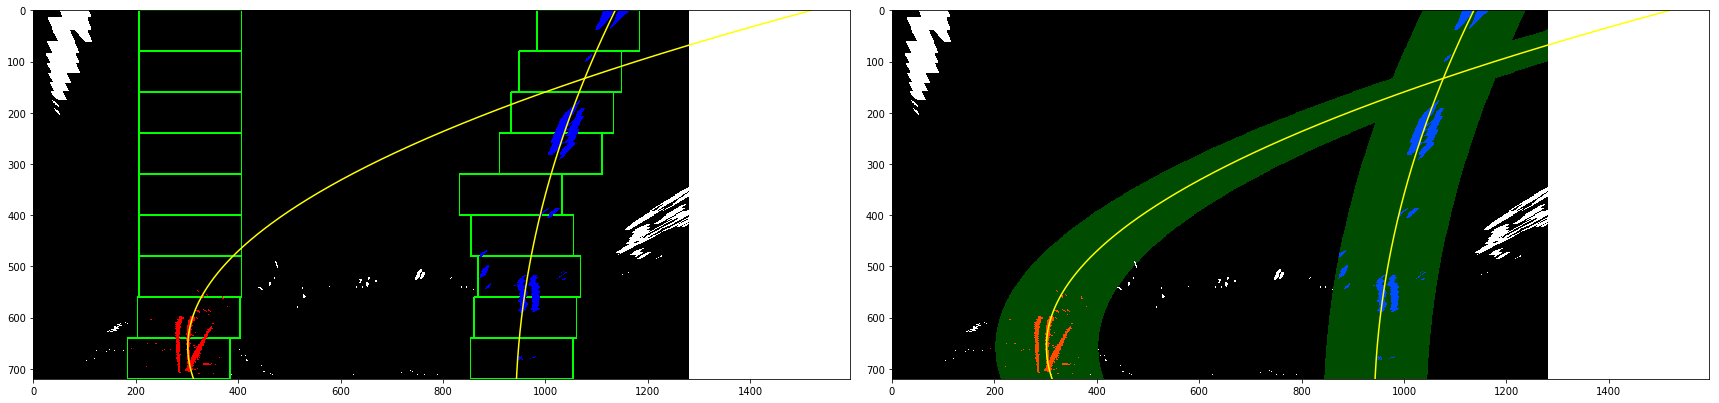

58.34656962231624 m 531.7044882686749 m


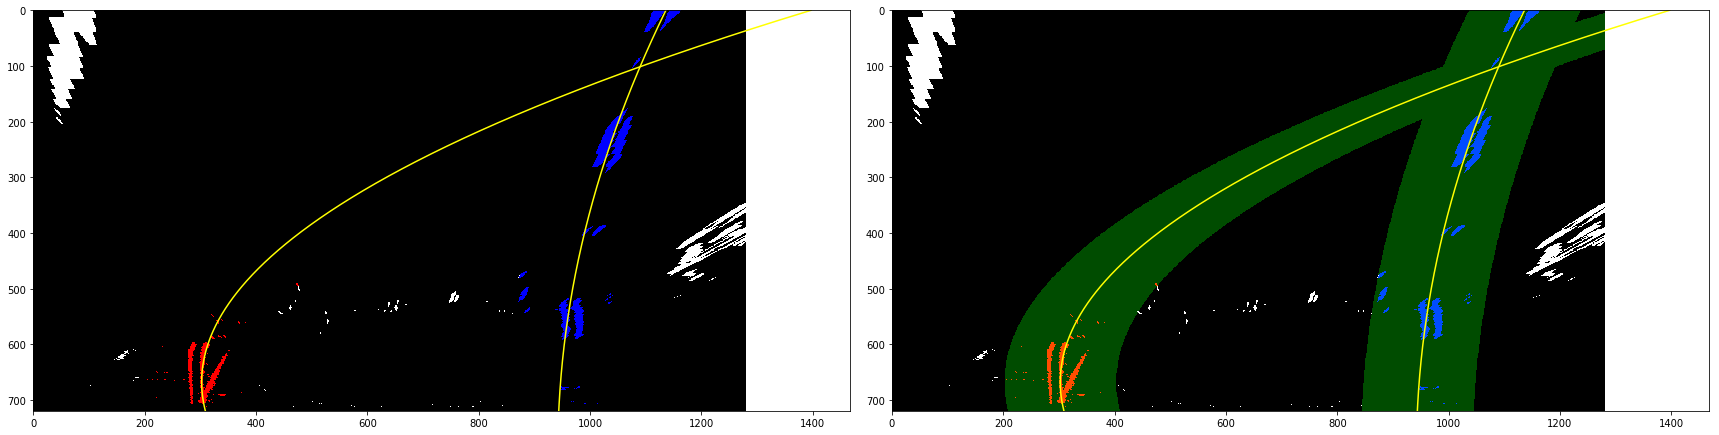

66.96670520684408 m 534.3401608722763 m


In [87]:
#Code Cell 13
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()        
binary_warped = np.copy(warped)
slideW = SlidingWindow()
out_img = slideW.sliding_window_polyfit(binary_warped)
slideW.plot_windows(binary_warped,out_img, ax1)


result = slideW.plot_poly(binary_warped,ax2)


plt.show()

left_curverad, right_curverad= slideW.calc_curve()

print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

image = mpimg.imread('./test_images/test6.jpg')
stacked, combined = pipeline(image)

M,Minv = get_transform_matrix()
img_size = (processed.shape[1], processed.shape[0])
warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()       
binary_warped = np.copy(warped)

out_img = slideW.no_sliding_polyfit(binary_warped)
slideW.plot_windows(binary_warped,out_img,ax1)


result = slideW.plot_poly(binary_warped,ax2)

plt.show()

left_curverad, right_curverad= slideW.calc_curve()

print(left_curverad, 'm', right_curverad, 'm')

First Pass
./test_images/test5.jpg
First Pass


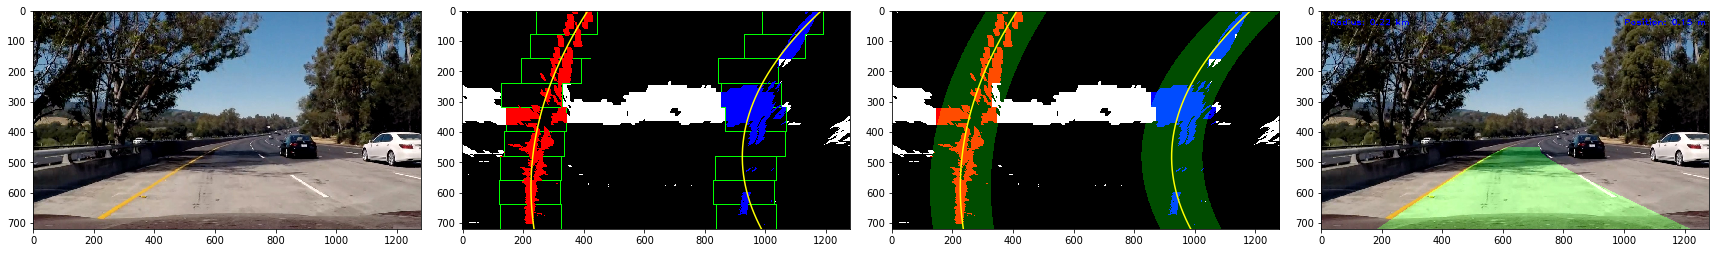

299.30959191523795 m 147.88700742707138 m
./test_images/test6.jpg


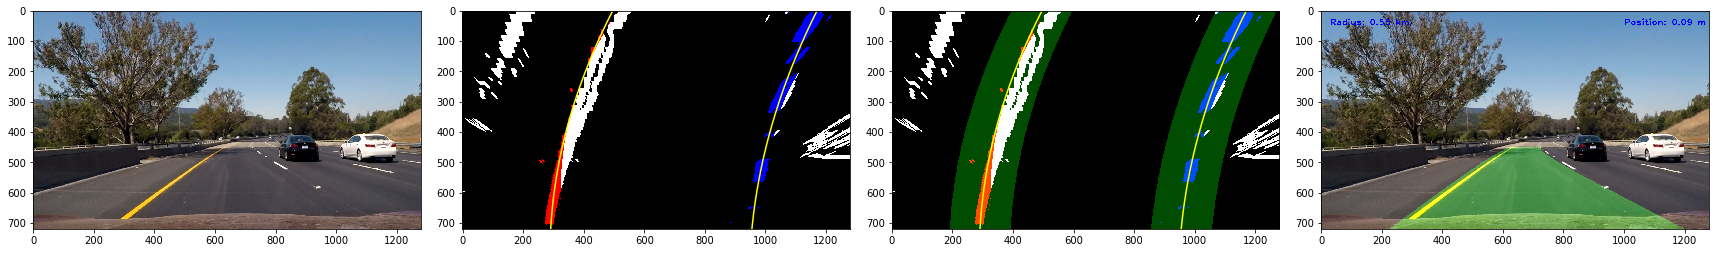

517.5155119425275 m 587.6734254513968 m
./test_images/test7.jpg


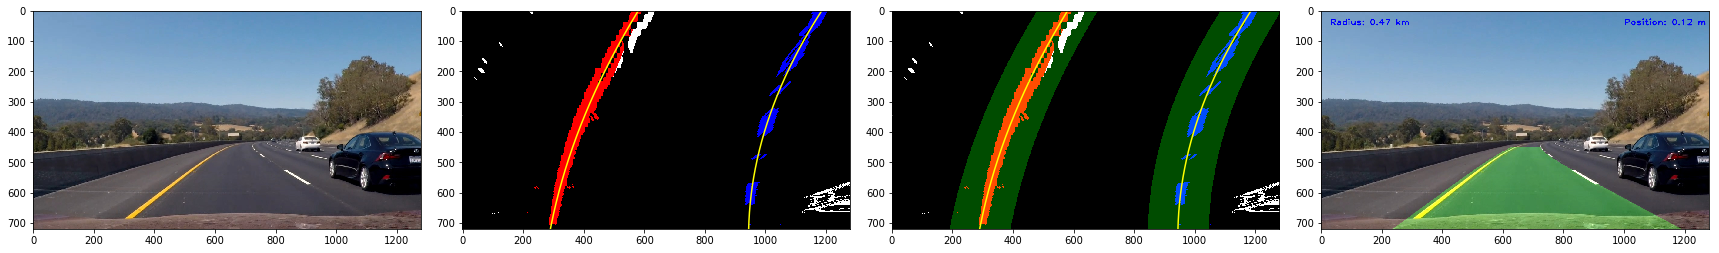

567.1332482441588 m 380.881707402845 m
./test_images/test8.jpg


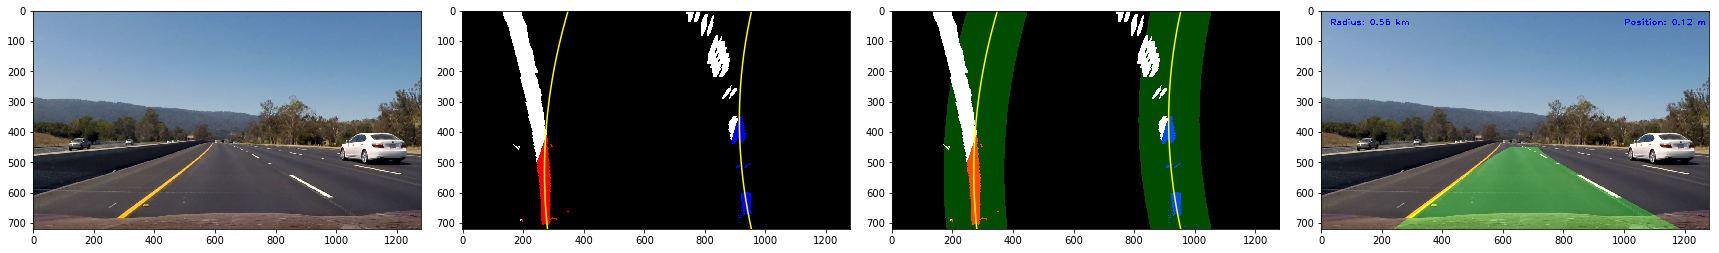

591.9417720031419 m 532.2325277684752 m
./test_images/test9.jpg


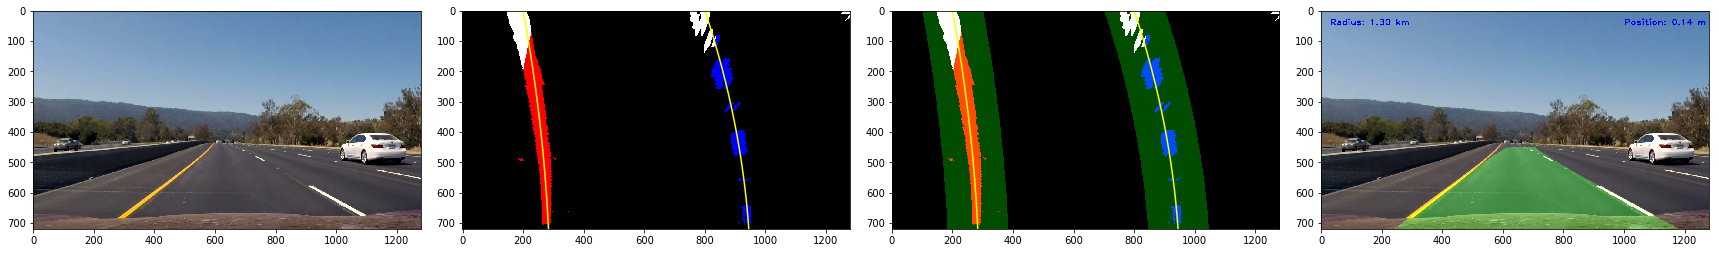

1708.7364007340657 m 896.491143494679 m
./test_images/test10.jpg
Old: 1708.7364007340657  New: 63.99472164886537 Diff: 1644.7416790852003
Old: 896.491143494679  New: 208.74729103532178 Diff: 687.7438524593572
First Pass


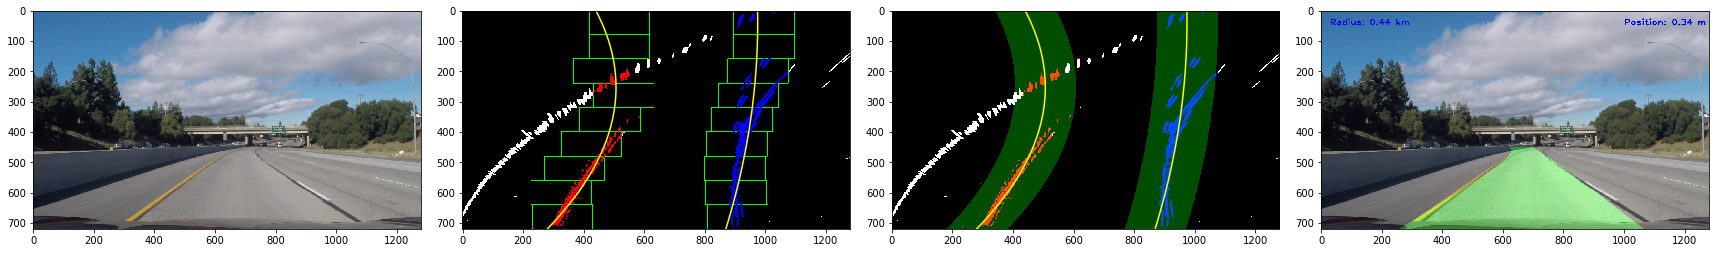

161.89741958484618 m 727.1934622595866 m
./test_images/test11.jpg
Old: 161.89741958484618  New: 2237.875519551372 Diff: 2075.9780999665254
First Pass


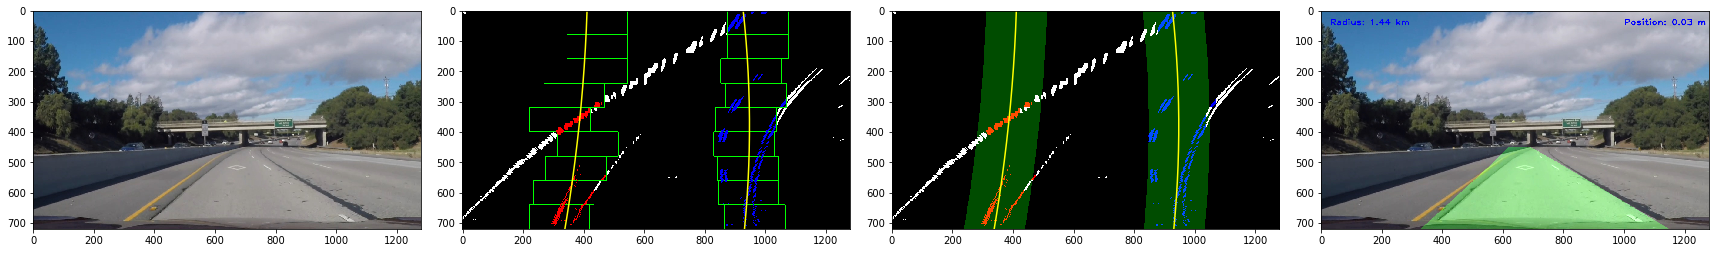

1730.7154347503808 m 1151.801147432743 m


In [88]:
#Code Cell 14
images = glob.glob("./test_images/test*.jpg")

slide = SlidingWindow()
for n in range(5,12):

    fname = "./test_images/test%d.jpg" % n
    print (fname)
    image = mpimg.imread(fname)
    stacked, processed = pipeline(image)
    
    h,w= processed.shape[:2]
    triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
    processed = remove_region(processed, triangle)
    
    M,Inv = get_transform_matrix()
    img_size = (processed.shape[1], processed.shape[0])
    warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

    f, ax = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout() 
    ax[0].imshow(image)
    binary_warped = np.copy(warped)

    out_img = slide.polyfit(binary_warped)

    slide.plot_windows(binary_warped,out_img,ax[1])

    result = slide.plot_poly(binary_warped,ax[2])

    lanes = slide.drawLane(binary_warped,image,Minv)
    lanes = slide.drawData(lanes)

    ax[3].imshow(lanes)

    plt.show()

    left_curverad, right_curverad= slide.calc_curve()

    print(left_curverad, 'm', right_curverad, 'm')

In [53]:
#Code Cell 15
videoSlide = SlidingWindow()


def process_image(image):

    stacked, processed = pipeline(image)
    
    h,w= processed.shape[:2]
    triangle = np.array([[350, h], [w-300, h], [w//2, 500]], np.int32)
    processed = remove_region(processed, triangle)
    
    M,Inv = get_transform_matrix()
    img_size = (processed.shape[1], processed.shape[0])
    warped = cv2.warpPerspective(processed, M, img_size, flags=cv2.INTER_LINEAR)

    binary_warped = np.copy(warped)

    out_img = videoSlide.polyfit(binary_warped)

    lanes = videoSlide.drawLane(binary_warped,image,Minv)

    lanes = videoSlide.drawData(lanes)
    return lanes

First Pass


In [52]:
#Code Cell 16
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
#clip1 = clip1.set_start(0.0)
#clip1 = clip1.set_duration(4.0)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

First Pass
[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


  2%|▏         | 31/1261 [00:08<05:50,  3.51it/s]

Old: 574.8440701590654  New: 251.91708230875628 Diff: 322.9269878503091
First Pass


  3%|▎         | 32/1261 [00:08<05:57,  3.43it/s]

Old: 1814.4613901069295  New: 891.4268339277353 Diff: 923.0345561791942
First Pass


  3%|▎         | 40/1261 [00:11<05:42,  3.56it/s]

Old: 2729.3627077560395  New: 1348.7693297170426 Diff: 1380.593378038997
First Pass


  4%|▍         | 53/1261 [00:14<05:39,  3.56it/s]

Old: 3030.9115967276057  New: 1045.7722198640859 Diff: 1985.1393768635198
First Pass


  4%|▍         | 54/1261 [00:14<05:47,  3.47it/s]

Old: 1153.7979608297107  New: 631.9420363574326 Diff: 521.8559244722782
First Pass


  8%|▊         | 99/1261 [00:27<05:28,  3.54it/s]

KeyboardInterrupt: 

In [89]:
#Code Cell 17
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_videos_output/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = clip1.set_start(0.0)
#clip1 = clip1.set_duration(4.0)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Old: 126.60335717927937  New: 46.21356442563138 Diff: 80.38979275364798
First Pass
[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4



  1%|          | 3/485 [00:00<02:26,  3.29it/s]

Old: 1690.2840752934085  New: 10127.389987168131 Diff: 8437.105911874723
First Pass



  1%|          | 4/485 [00:01<02:29,  3.22it/s]

Old: 11760.035214514062  New: 3356.267017864777 Diff: 8403.768196649286
First Pass



  2%|▏         | 9/485 [00:02<02:28,  3.20it/s]

Old: 10834.488593482494  New: 3865.230903912209 Diff: 6969.257689570285
First Pass



  2%|▏         | 10/485 [00:03<02:29,  3.17it/s]

Old: 7037.8811783684505  New: 2162.819847166242 Diff: 4875.061331202209
First Pass



  5%|▍         | 23/485 [00:06<02:19,  3.32it/s]

Old: 2680.742049012385  New: 265.64796091759666 Diff: 2415.0940880947883
First Pass



  5%|▍         | 24/485 [00:07<02:21,  3.26it/s]

Old: 355.86205427592574  New: 152.54557368388654 Diff: 203.3164805920392
First Pass



  5%|▌         | 25/485 [00:07<02:22,  3.24it/s]

Old: 2519.2042953920322  New: 1366.538080907068 Diff: 1152.6662144849643
First Pass



  6%|▋         | 31/485 [00:09<02:19,  3.25it/s]

Old: 1610.2022512398094  New: 242.77700323982643 Diff: 1367.425247999983
First Pass



  7%|▋         | 32/485 [00:09<02:19,  3.24it/s]

Old: 317.37335196330224  New: 3095.629767385299 Diff: 2778.2564154219967
First Pass



  7%|▋         | 34/485 [00:10<02:17,  3.28it/s]

Old: 424.101227805248  New: 109.89260675771642 Diff: 314.2086210475316
First Pass



  7%|▋         | 35/485 [00:10<02:18,  3.24it/s]

Old: 868.5458823712055  New: 200.0566284551807 Diff: 668.4892539160248
First Pass



  7%|▋         | 36/485 [00:10<02:18,  3.23it/s]

Old: 593.9126602908844  New: 74.60177781865916 Diff: 519.3108824722253
First Pass



  8%|▊         | 37/485 [00:11<02:18,  3.22it/s]

Old: 213.94200898818664  New: 50.67064955731402 Diff: 163.27135943087262
Old: 1385.0551871246978  New: 738.3767972383583 Diff: 646.6783898863395
First Pass



  8%|▊         | 38/485 [00:11<02:19,  3.20it/s]

Old: 92.76107373343393  New: 43.083271620867386 Diff: 49.677802112566546
Old: 686.4016116518527  New: 209.70323833022786 Diff: 476.69837332162484
First Pass



  8%|▊         | 39/485 [00:11<02:19,  3.19it/s]

Old: 96.6448435953821  New: 42.92310419511794 Diff: 53.721739400264156
First Pass



  8%|▊         | 40/485 [00:12<02:19,  3.20it/s]

Old: 91.53507738082807  New: 42.08125035714886 Diff: 49.45382702367921
First Pass



 13%|█▎        | 64/485 [00:19<02:04,  3.37it/s]

Old: 815.9953629442093  New: 445.9345709129051 Diff: 370.06079203130423
First Pass



 14%|█▍        | 68/485 [00:20<02:04,  3.36it/s]

Old: 479.16673600002974  New: 254.46748209430126 Diff: 224.69925390572848
First Pass



 14%|█▍        | 69/485 [00:20<02:05,  3.32it/s]

Old: 629.7863829582897  New: 3336.9921423425026 Diff: 2707.205759384213
First Pass



 21%|██        | 100/485 [00:29<01:52,  3.44it/s]

Old: 205.98568358216727  New: 1127.932155657794 Diff: 921.9464720756268
First Pass



 25%|██▌       | 123/485 [00:36<01:48,  3.34it/s]

Old: 551.088816186704  New: 236.9676195647095 Diff: 314.1211966219945
First Pass



 26%|██▌       | 127/485 [00:37<01:47,  3.33it/s]

Old: 1132.0879827090782  New: 404.49282178063186 Diff: 727.5951609284464
First Pass



 26%|██▋       | 128/485 [00:38<01:47,  3.31it/s]

Old: 74.02098069443818  New: 35.88148864992849 Diff: 38.13949204450969
First Pass



 27%|██▋       | 131/485 [00:39<01:45,  3.36it/s]

Old: 93.15791744150904  New: 39.629257029667905 Diff: 53.52866041184114
First Pass



 28%|██▊       | 134/485 [00:39<01:45,  3.33it/s]

Old: 142.3033027201544  New: 72.220779105385 Diff: 70.08252361476939
First Pass



 43%|████▎     | 209/485 [01:03<01:24,  3.29it/s]

Old: 401.6769969376231  New: 194.48394457277203 Diff: 207.19305236485104
First Pass



 70%|███████   | 341/485 [01:44<00:46,  3.09it/s]

Old: 1482.5948873370178  New: 726.8296048028307 Diff: 755.7652825341871
First Pass



 80%|████████  | 389/485 [01:59<00:30,  3.11it/s]

Old: 545.0332407212857  New: 3358.3042809881176 Diff: 2813.2710402668317
First Pass



 80%|████████  | 390/485 [01:59<00:34,  2.75it/s]

Old: 3358.3042809870767  New: 659.2482500231291 Diff: 2699.0560309639477
First Pass



 81%|████████▏ | 395/485 [02:01<00:29,  3.04it/s]

Old: 982.2832780397639  New: 523.3303073596109 Diff: 458.95297068015304
First Pass



 82%|████████▏ | 399/485 [02:02<00:27,  3.17it/s]

Old: 1016.2620501291647  New: 523.5095858522654 Diff: 492.7524642768992
First Pass



 82%|████████▏ | 400/485 [02:02<00:27,  3.13it/s]

Old: 6322.3531194700345  New: 917.279689830207 Diff: 5405.073429639828
First Pass



 83%|████████▎ | 401/485 [02:03<00:27,  3.10it/s]

Old: 3869.1750772858454  New: 1585.1415757479651 Diff: 2284.0335015378805
First Pass



 84%|████████▎ | 405/485 [02:04<00:25,  3.15it/s]

Old: 5075.002254366115  New: 1108.7992345983962 Diff: 3966.203019767719
First Pass



 84%|████████▍ | 408/485 [02:05<00:24,  3.10it/s]

Old: 567.362066019122  New: 305.25889567892466 Diff: 262.1031703401974
First Pass



 84%|████████▍ | 409/485 [02:05<00:24,  3.08it/s]

Old: 4137.3177035178705  New: 1260.2755157095703 Diff: 2877.0421878083002
First Pass



 85%|████████▍ | 410/485 [02:06<00:24,  3.09it/s]

Old: 4901.508536811504  New: 1090.6866559167695 Diff: 3810.821880894735
First Pass



 85%|████████▌ | 414/485 [02:07<00:22,  3.10it/s]

Old: 7306.723665483921  New: 2385.574231271971 Diff: 4921.1494342119495
First Pass



 86%|████████▌ | 415/485 [02:07<00:22,  3.09it/s]

Old: 5801.332587499469  New: 1658.8795609886026 Diff: 4142.453026510866
First Pass



 86%|████████▋ | 419/485 [02:08<00:21,  3.14it/s]

Old: 2320.5516755335398  New: 674.7102704347373 Diff: 1645.8414050988026
First Pass



 87%|████████▋ | 420/485 [02:09<00:20,  3.14it/s]

Old: 2160.8511257248265  New: 1168.382505813195 Diff: 992.4686199116315
First Pass



 87%|████████▋ | 422/485 [02:09<00:20,  3.12it/s]

Old: 1393.482736228214  New: 9139.525652380691 Diff: 7746.042916152477
First Pass



 87%|████████▋ | 423/485 [02:10<00:19,  3.11it/s]

Old: 9139.52565241541  New: 4592.568078847589 Diff: 4546.957573567821
First Pass



 87%|████████▋ | 424/485 [02:10<00:19,  3.11it/s]

Old: 369.5664698776583  New: 192.26149388125515 Diff: 177.30497599640313
First Pass



 88%|████████▊ | 425/485 [02:10<00:19,  3.11it/s]

Old: 355.58742934175757  New: 188.4899857036887 Diff: 167.09744363806888
First Pass



 88%|████████▊ | 426/485 [02:11<00:19,  3.10it/s]

Old: 5621.731081325  New: 1288.583358435126 Diff: 4333.147722889874
First Pass



 88%|████████▊ | 427/485 [02:11<00:18,  3.13it/s]

Old: 1689.1274960466383  New: 596.3215558769895 Diff: 1092.8059401696487
First Pass



 88%|████████▊ | 428/485 [02:11<00:18,  3.14it/s]

Old: 3839.1551959046747  New: 224.18470580844385 Diff: 3614.9704900962306
Old: 2324.6016058442624  New: 504.15246726811574 Diff: 1820.4491385761467
First Pass



 88%|████████▊ | 429/485 [02:12<00:17,  3.14it/s]

Old: 1550.0436696137956  New: 603.8221045707802 Diff: 946.2215650430154
First Pass



 89%|████████▊ | 430/485 [02:12<00:17,  3.14it/s]

Old: 3367.3369031710104  New: 1271.1589149830627 Diff: 2096.1779881879474
First Pass



 89%|████████▉ | 431/485 [02:12<00:17,  3.15it/s]

Old: 4617.166469707915  New: 1084.5776557693944 Diff: 3532.5888139385206
First Pass



 89%|████████▉ | 433/485 [02:13<00:16,  3.14it/s]

Old: 1952.623902630303  New: 29998.041312116413 Diff: 28045.41740948611
First Pass



 89%|████████▉ | 434/485 [02:13<00:16,  3.09it/s]

Old: 2016.925857828767  New: 11947.362797448972 Diff: 9930.436939620206
Old: 6454.4438320609015  New: 337988.651735093 Diff: 331534.2079030321
First Pass



 90%|████████▉ | 435/485 [02:14<00:16,  3.10it/s]

Old: 8052.007399864244  New: 48594.99936910155 Diff: 40542.99196923731
Old: 9115.309790216748  New: 4197.392973412282 Diff: 4917.916816804466
First Pass



 90%|████████▉ | 436/485 [02:14<00:15,  3.10it/s]

Old: 56218.85186014677  New: 26485.202824011896 Diff: 29733.649036134877
Old: 6686.136444789452  New: 714.677651737677 Diff: 5971.4587930517755
First Pass



 90%|█████████ | 437/485 [02:14<00:15,  3.12it/s]

Old: 10761.969401221439  New: 1658.0361450221435 Diff: 9103.933256199296
First Pass



 90%|█████████ | 438/485 [02:15<00:14,  3.16it/s]

Old: 3050.0095430633387  New: 939.5282117650216 Diff: 2110.481331298317
First Pass



 91%|█████████ | 440/485 [02:15<00:13,  3.28it/s]

Old: 5433.9591416557305  New: 636.2985471592117 Diff: 4797.660594496519
First Pass



 91%|█████████ | 441/485 [02:15<00:13,  3.31it/s]

Old: 1801.655611607665  New: 711.331141109087 Diff: 1090.324470498578
First Pass



 91%|█████████ | 442/485 [02:16<00:13,  3.24it/s]

Old: 586479.3313696346  New: 813.4963675182189 Diff: 585665.8350021164
First Pass



 91%|█████████▏| 443/485 [02:16<00:13,  3.20it/s]

Old: 1756.879356228023  New: 842.6922495614326 Diff: 914.1871066665904
First Pass



 92%|█████████▏| 444/485 [02:16<00:12,  3.23it/s]

Old: 1718.0121243573456  New: 583.082999553984 Diff: 1134.9291248033614
First Pass



 92%|█████████▏| 445/485 [02:17<00:12,  3.25it/s]

Old: 1344.36628099929  New: 562.9071624530322 Diff: 781.4591185462577
First Pass



 92%|█████████▏| 447/485 [02:17<00:11,  3.30it/s]

Old: 332.7074013424887  New: 5827.859471456006 Diff: 5495.152070113517
First Pass



 93%|█████████▎| 452/485 [02:19<00:10,  3.21it/s]

Old: 401.2567790638473  New: 219.3580725816087 Diff: 181.89870648223862
First Pass



 93%|█████████▎| 453/485 [02:19<00:10,  3.13it/s]

Old: 734.525865651193  New: 258.70242831835486 Diff: 475.8234373328382
First Pass



 94%|█████████▎| 454/485 [02:19<00:10,  3.05it/s]

Old: 16242.414367660384  New: 244390.1843860969 Diff: 228147.7700184365
First Pass



 94%|█████████▍| 456/485 [02:20<00:09,  3.14it/s]

Old: 635.219661193221  New: 289.1489501763523 Diff: 346.0707110168687
First Pass



 94%|█████████▍| 457/485 [02:20<00:08,  3.13it/s]

Old: 572.6652303631961  New: 301.5774672097197 Diff: 271.0877631534764
First Pass



 95%|█████████▍| 459/485 [02:21<00:08,  3.16it/s]

Old: 283.63055023891275  New: 2136.8969117583047 Diff: 1853.266361519392
First Pass



 95%|█████████▍| 460/485 [02:21<00:07,  3.15it/s]

Old: 1093.137044906989  New: 530.3523392408648 Diff: 562.7847056661243
First Pass



 95%|█████████▌| 463/485 [02:22<00:06,  3.22it/s]

Old: 1160.016297162047  New: 399.76165181817527 Diff: 760.2546453438717
First Pass



 96%|█████████▌| 464/485 [02:23<00:06,  3.24it/s]

Old: 2801.404074909011  New: 1326.775642699556 Diff: 1474.6284322094548
First Pass



 96%|█████████▌| 465/485 [02:23<00:06,  3.14it/s]

Old: 7237.878146154642  New: 445.8034488672226 Diff: 6792.074697287419
First Pass



 96%|█████████▌| 466/485 [02:23<00:06,  3.10it/s]

Old: 816.5054804101688  New: 290.3922239923197 Diff: 526.1132564178491
First Pass



 96%|█████████▋| 467/485 [02:24<00:05,  3.10it/s]

Old: 500.04813798640805  New: 191.68100352283966 Diff: 308.3671344635684
First Pass



 96%|█████████▋| 468/485 [02:24<00:05,  3.07it/s]

Old: 439.73811756970514  New: 244.01280001066627 Diff: 195.72531755903887
First Pass



 97%|█████████▋| 470/485 [02:25<00:04,  3.10it/s]

Old: 587.690356204727  New: 185.86540309063616 Diff: 401.8249531140908
First Pass



 97%|█████████▋| 471/485 [02:25<00:04,  3.08it/s]

Old: 1015.9171296889865  New: 185.12159082350232 Diff: 830.7955388654842
Old: 599.9544443035226  New: 235.28819513479385 Diff: 364.6662491687287
First Pass



 97%|█████████▋| 472/485 [02:25<00:04,  3.07it/s]

Old: 433.0924083156544  New: 148.84760687422607 Diff: 284.2448014414283
First Pass



 98%|█████████▊| 473/485 [02:26<00:03,  3.07it/s]

Old: 930.7716448443404  New: 498.9353823567419 Diff: 431.83626248759845
Old: 3387.5864724758203  New: 576.124613600392 Diff: 2811.4618588754283
First Pass



 98%|█████████▊| 474/485 [02:26<00:03,  3.10it/s]

Old: 2202.6273115191816  New: 938.4667665676361 Diff: 1264.1605449515455
First Pass



 98%|█████████▊| 475/485 [02:26<00:03,  3.12it/s]

Old: 3208.689757090057  New: 1367.07970022838 Diff: 1841.6100568616769
First Pass



 98%|█████████▊| 476/485 [02:26<00:02,  3.12it/s]

Old: 805.5580905652354  New: 182.00860655213168 Diff: 623.5494840131037
Old: 66407.3876310349  New: 2185.011245026961 Diff: 64222.37638600794
First Pass



 98%|█████████▊| 477/485 [02:27<00:02,  3.16it/s]

Old: 217.8914814825598  New: 115.83561525456332 Diff: 102.05586622799649
Old: 32238.997699247288  New: 880.806905650618 Diff: 31358.19079359667
First Pass



 99%|█████████▊| 478/485 [02:27<00:02,  3.18it/s]

Old: 811.5880330912123  New: 380.918252808368 Diff: 430.66978028284433
First Pass



100%|██████████| 485/485 [02:29<00:00,  3.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 2min 57s, sys: 39.9 s, total: 3min 37s
Wall time: 2min 30s


## Convolutional Approach
(Not Used, just for experimentation. Didn't seem as good as previous)

## Perspective Transform
